In [32]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from joblib import dump, load

In [76]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_absolute_error

#import sklearn
from sklearn import tree
#from sklearn import metrics
#from sklearn.metrics import precision_score, confusion_matrix, ConfusionMatrixDisplay
#from sklearn.datasets import make_regression



## Importing data and preparing it for ML

In [34]:
#import cleaned data
df = pd.read_csv("../Explainer/AB_data_clean.csv")
df.head(2)

id                                name  host_id host_name  \
0  2539  Clean & quiet apt home by the park     2787      John   
1  2595               Skylit Midtown Castle     2845  Jennifer   

  neighbourhood_group neighbourhood  latitude  longitude        room_type  \
0            Brooklyn    Kensington  40.64749  -73.97237     Private room   
1           Manhattan       Midtown  40.75362  -73.98377  Entire home/apt   

   price  ...  neighbourhood_other  neighbourhood_other_label  \
0    149  ...                Other                         29   
1    225  ...              Midtown                         25   

  neighbourhood_group_Bronx  neighbourhood_group_Brooklyn  \
0                       0.0                           1.0   
1                       0.0                           0.0   

   neighbourhood_group_Manhattan  neighbourhood_group_Queens  \
0                            0.0                         0.0   
1                            1.0                         0.0   

  neighbourhood_group_Staten Island  room_type_Entire home/apt  \
0                               0.0                        0.0   
1                               0.0                        1.0   

   room_type_Private room  room_type_Shared room  
0                     1.0                    0.0  
1                     0.0                    0.0  

[2 rows x 26 columns]

In [35]:
#manage Na values in dataframe
df.isna().sum()

id                                      0
name                                   15
host_id                                 0
host_name                              21
neighbourhood_group                     0
neighbourhood                           0
latitude                                0
longitude                               0
room_type                               0
price                                   0
minimum_nights                          0
number_of_reviews                       0
last_review                          9913
reviews_per_month                    9913
calculated_host_listings_count          0
availability_365                        0
neighbourhood_other                     0
neighbourhood_other_label               0
neighbourhood_group_Bronx               0
neighbourhood_group_Brooklyn            0
neighbourhood_group_Manhattan           0
neighbourhood_group_Queens              0
neighbourhood_group_Staten Island       0
room_type_Entire home/apt         

In [36]:
print(df[df['last_review'].isna()].groupby('number_of_reviews').size())
print(df[df['reviews_per_month'].isna()].groupby('number_of_reviews').size())

number_of_reviews
0    9913
dtype: int64
number_of_reviews
0    9913
dtype: int64


In [37]:
df['last_review'] = df['last_review'].fillna(0)
df['reviews_per_month'] = df['reviews_per_month'].fillna(0)

In [38]:
# df[df.isna().any(axis=1)].head()
# df=df.dropna()#drop remaining 37 Nan values, 16 from name and 21 from host name 

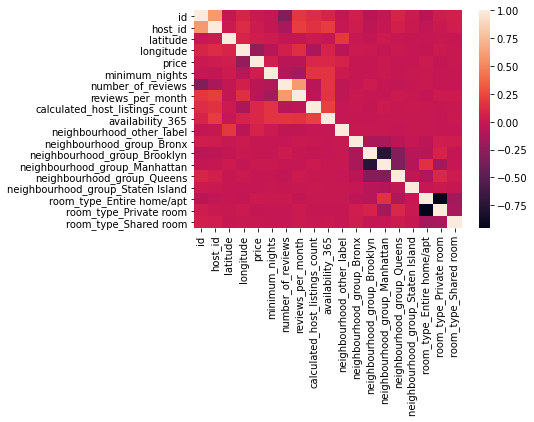

In [39]:
#correlation matrix giving an overview of how our colums relate to one another
sns.heatmap(df.corr())
plt.show()

### Making datasets for the machine learning algorithm

In [40]:
df.columns

Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365', 'neighbourhood_other', 'neighbourhood_other_label',
       'neighbourhood_group_Bronx', 'neighbourhood_group_Brooklyn',
       'neighbourhood_group_Manhattan', 'neighbourhood_group_Queens',
       'neighbourhood_group_Staten Island', 'room_type_Entire home/apt',
       'room_type_Private room', 'room_type_Shared room'],
      dtype='object')

In [41]:
#chose which featues not to include in the calculation
features = df.drop(['price',
                    'id', 
                    'name', 
                    'host_id', 
                    'host_name', 
                    'neighbourhood_group',
                    'neighbourhood', 
                    'room_type',
                    'last_review',#dropped until we encode it to not datetime
                    'neighbourhood_other'], axis=1)
target = df.price

print(features.columns)

Index(['latitude', 'longitude', 'minimum_nights', 'number_of_reviews',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365', 'neighbourhood_other_label',
       'neighbourhood_group_Bronx', 'neighbourhood_group_Brooklyn',
       'neighbourhood_group_Manhattan', 'neighbourhood_group_Queens',
       'neighbourhood_group_Staten Island', 'room_type_Entire home/apt',
       'room_type_Private room', 'room_type_Shared room'],
      dtype='object')


## Baseline model linear regression

In [42]:
scaler = StandardScaler()
base_features = scaler.fit_transform(features)

test_fraction = 0.2

# This is a stratified split:
X_train, X_test, y_train, y_test = train_test_split(base_features, target, test_size = test_fraction, random_state=3546)
#Display how many samples are chosen for training and test, respectively
print('Training Features Shape:', X_train.shape,'\tTesting Features Shape:\t', X_test.shape)
print('Training Labels Shape:\t', y_train.shape, '\tTesting Labels Shape:\t', y_test.shape)

Training Features Shape: (38970, 16) 	Testing Features Shape:	 (9743, 16)
Training Labels Shape:	 (38970,) 	Testing Labels Shape:	 (9743,)


In [43]:
reg_lin = LinearRegression().fit(X_train, y_train)
y_pred = reg_lin.predict(X_test)
print(f'Mean absolute error (on test data): {round(mean_absolute_error(y_test, y_pred),4)}')

Mean absolute error (on test data): 79.4866


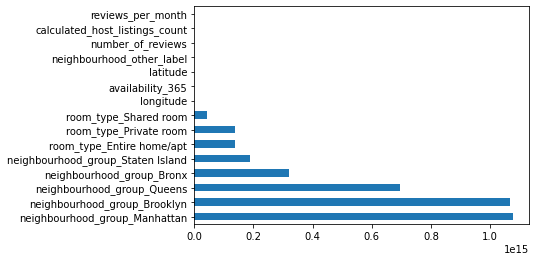

In [44]:
pd.Series(np.abs(reg_lin.coef_), index=features.columns).nlargest(15).plot(kind='barh')
plt.show()

## Decision Tree

In [45]:
test_fraction = 0.2

# This is a stratified split:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = test_fraction, random_state=3546)
#Display how many samples are chosen for training and test, respectively
print('Training Features Shape:', X_train.shape,'\tTesting Features Shape:\t', X_test.shape)
print('Training Labels Shape:\t', y_train.shape, '\tTesting Labels Shape:\t', y_test.shape)

Training Features Shape: (38970, 16) 	Testing Features Shape:	 (9743, 16)
Training Labels Shape:	 (38970,) 	Testing Labels Shape:	 (9743,)


In [46]:
parameters = {'criterion':('mse', 'poisson'), 'max_depth':[1, 5, 10, 15, 20]} #'friedman_mse' gives same results as mse, mae is 60 times slower then mse and poisson

reg_tree = DecisionTreeRegressor(random_state=3546) # random state is set so as to guarantee the same outcome every time
reg_seach = GridSearchCV(reg_tree, parameters, scoring='neg_mean_absolute_error', refit=True, )#verbose=4)

reg_seach.fit(X_train, y_train)

GridSearchCV(estimator=DecisionTreeRegressor(random_state=3546),
             param_grid={'criterion': ('mse', 'poisson'),
                         'max_depth': [1, 5, 10, 15, 20]},
             scoring='neg_mean_absolute_error')

In [47]:
df_reg_tree = pd.DataFrame(reg_seach.cv_results_).sort_values('rank_test_score')
df_reg_tree.head(2)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
2       0.344136      0.031923         0.009351        0.001209   
1       0.180028      0.005640         0.007295        0.001075   

  param_criterion param_max_depth                                 params  \
2             mse              10  {'criterion': 'mse', 'max_depth': 10}   
1             mse               5   {'criterion': 'mse', 'max_depth': 5}   

   split0_test_score  split1_test_score  split2_test_score  split3_test_score  \
2         -70.131751         -71.948972         -73.823899         -71.713050   
1         -71.746204         -72.710705         -72.873362         -71.709156   

   split4_test_score  mean_test_score  std_test_score  rank_test_score  
2         -71.073480        -71.73823        1.218009                1  
1         -71.227623        -72.05341        0.632324                2

In [48]:
reg_tree_best = reg_seach.best_estimator_
y_pred = reg_tree_best.predict(X_test)

print(f'Decision tree has {reg_tree_best.tree_.node_count} nodes with maximum depth {reg_tree_best.tree_.max_depth}.')
print(f'Mean absolute error (on test data): {round(mean_absolute_error(y_test, y_pred),4)}')

Decision tree has 1133 nodes with maximum depth 10.
Mean absolute error (on test data): 71.0034


In [77]:
# Display tree
fig, axes = plt.subplots(nrows = 1,ncols = 1, figsize=(25,20), dpi=500)
tree.plot_tree(reg_tree_best, feature_names=features.columns, filled = True)
fig.savefig('tree.jpeg')

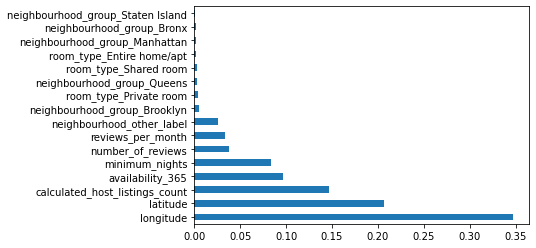

In [50]:
pd.Series(reg_tree_best.feature_importances_, index=features.columns).nlargest(20).plot(kind='barh')
plt.show()

## Random Forest

In [51]:
test_fraction = 0.2

# This is a stratified split:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = test_fraction, random_state=3546)
#Display how many samples are chosen for training and test, respectively
print('Training Features Shape:', X_train.shape,'\tTesting Features Shape:\t', X_test.shape)
print('Training Labels Shape:\t', y_train.shape, '\tTesting Labels Shape:\t', y_test.shape)

Training Features Shape: (38970, 16) 	Testing Features Shape:	 (9743, 16)
Training Labels Shape:	 (38970,) 	Testing Labels Shape:	 (9743,)


In [52]:
parameters = {'n_estimators':[10, 50, 100, 150, 200], 'criterion':('mse',), 'max_depth':[10, 20, None]} # mae is again more than 60 times slower than mse

reg_forest = RandomForestRegressor(random_state=3546) # random state is set so as to guarantee the same outcome every time
reg_seach = GridSearchCV(reg_forest, parameters, scoring='neg_mean_absolute_error', refit=True, )#verbose=4)

reg_seach.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestRegressor(random_state=3546),
             param_grid={'criterion': ('mse',), 'max_depth': [10, 20, None],
                         'n_estimators': [10, 50, 100, 150, 200]},
             scoring='neg_mean_absolute_error')

In [53]:
df_reg_forest = pd.DataFrame(reg_seach.cv_results_).sort_values('rank_test_score')
df_reg_forest.head(2)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
4      45.143799      2.516954         0.385899        0.037960   
3      34.621709      1.057042         0.301916        0.020913   

  param_criterion param_max_depth param_n_estimators  \
4             mse              10                200   
3             mse              10                150   

                                              params  split0_test_score  \
4  {'criterion': 'mse', 'max_depth': 10, 'n_estim...         -66.869343   
3  {'criterion': 'mse', 'max_depth': 10, 'n_estim...         -66.861770   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score  \
4         -67.612613         -68.225995         -66.970215         -67.024029   
3         -67.626377         -68.225444         -67.027251         -67.097402   

   mean_test_score  std_test_score  rank_test_score  
4       -67.340439        0.513303                1  
3       -67.367649        0.499514                2

In [54]:
reg_forest_best = reg_seach.best_estimator_
y_pred = reg_forest_best.predict(X_test)

print(f'Mean absolute error (on test data): {round(mean_absolute_error(y_test, y_pred),4)}')

Mean absolute error (on test data): 68.6235


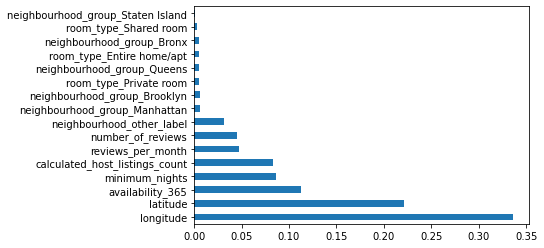

In [55]:
pd.Series(reg_forest_best.feature_importances_, index=features.columns).nlargest(20).plot(kind='barh')
plt.show()

## Random Forest with feature selection

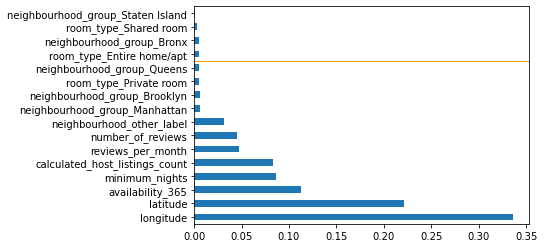

In [56]:
df_reg_forest_feat_im = pd.Series(reg_forest_best.feature_importances_, index=features.columns).nlargest(20)
threshold_feat_im = 0.005


threshold_plot = len(df_reg_forest_feat_im[df_reg_forest_feat_im>=threshold_feat_im])-0.5

df_reg_forest_feat_im.plot(kind='barh')
plt.axhline(y=threshold_plot,linewidth=1, color='orange')
plt.show()

In [57]:
#chose which featues not to include in the calculation
features_select = features.drop(df_reg_forest_feat_im[df_reg_forest_feat_im<threshold_feat_im].index, axis=1)
target = df.price

print(features_select.columns)

Index(['latitude', 'longitude', 'minimum_nights', 'number_of_reviews',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365', 'neighbourhood_other_label',
       'neighbourhood_group_Brooklyn', 'neighbourhood_group_Manhattan',
       'neighbourhood_group_Queens', 'room_type_Private room'],
      dtype='object')


In [58]:
test_fraction = 0.2

# This is a stratified split:
X_train, X_test, y_train, y_test = train_test_split(features_select, target, test_size = test_fraction, random_state=3546)
#Display how many samples are chosen for training and test, respectively
print('Training Features Shape:', X_train.shape,'\tTesting Features Shape:\t', X_test.shape)
print('Training Labels Shape:\t', y_train.shape, '\tTesting Labels Shape:\t', y_test.shape)

Training Features Shape: (38970, 12) 	Testing Features Shape:	 (9743, 12)
Training Labels Shape:	 (38970,) 	Testing Labels Shape:	 (9743,)


In [61]:
parameters = {'n_estimators':[10, 50, 100, 150, 200], 'criterion':('mse',), 'max_depth':[10, 20, None]} # mae is again more than 60 times slower than mse

reg_forest_select = RandomForestRegressor(random_state=3546) # random state is set so as to guarantee the same outcome every time
reg_seach = GridSearchCV(reg_forest_select, parameters, scoring='neg_mean_absolute_error', refit=True, )#verbose=4)

reg_seach.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestRegressor(random_state=3546),
             param_grid={'criterion': ('mse',), 'max_depth': [10, 20, None],
                         'n_estimators': [10, 50, 100, 150, 200]},
             scoring='neg_mean_absolute_error')

In [62]:
df_reg_forest_select = pd.DataFrame(reg_seach.cv_results_).sort_values('rank_test_score')
df_reg_forest_select.head(2)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
4      25.402642      0.300159         0.251938        0.003771   
2      13.399523      0.853090         0.139017        0.023172   

  param_criterion param_max_depth param_n_estimators  \
4             mse              10                200   
2             mse              10                100   

                                              params  split0_test_score  \
4  {'criterion': 'mse', 'max_depth': 10, 'n_estim...         -66.864296   
2  {'criterion': 'mse', 'max_depth': 10, 'n_estim...         -66.875706   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score  \
4         -67.513734         -68.240765         -66.962594         -66.921412   
2         -67.555974         -68.244212         -67.047758         -66.856761   

   mean_test_score  std_test_score  rank_test_score  
4       -67.300560        0.524925                1  
2       -67.316082        0.528371                2

In [63]:
reg_forest_select_best = reg_seach.best_estimator_
y_pred = reg_forest_select_best.predict(X_test)

print(f'Mean absolute error (on test data): {round(mean_absolute_error(y_test, y_pred),4)}')

Mean absolute error (on test data): 68.5127


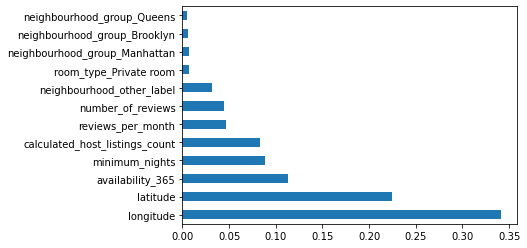

In [64]:
pd.Series(reg_forest_select_best.feature_importances_, index=features_select.columns).nlargest(20).plot(kind='barh')
plt.show()

## Random forest for the website

In [65]:
features_web = features.drop(['reviews_per_month',
                              'neighbourhood_other_label',
                              'neighbourhood_group_Bronx',
                              'neighbourhood_group_Brooklyn',
                              'neighbourhood_group_Manhattan', 
                              'neighbourhood_group_Queens',
                              'neighbourhood_group_Staten Island'], axis=1)
target = df.price

print(features_web.columns)

Index(['latitude', 'longitude', 'minimum_nights', 'number_of_reviews',
       'calculated_host_listings_count', 'availability_365',
       'room_type_Entire home/apt', 'room_type_Private room',
       'room_type_Shared room'],
      dtype='object')


In [66]:
test_fraction = 0.2

# This is a stratified split:
X_train, X_test, y_train, y_test = train_test_split(features_web, target, test_size = test_fraction, random_state=3546)
#Display how many samples are chosen for training and test, respectively
print('Training Features Shape:', X_train.shape,'\tTesting Features Shape:\t', X_test.shape)
print('Training Labels Shape:\t', y_train.shape, '\tTesting Labels Shape:\t', y_test.shape)

Training Features Shape: (38970, 9) 	Testing Features Shape:	 (9743, 9)
Training Labels Shape:	 (38970,) 	Testing Labels Shape:	 (9743,)


In [67]:
parameters = {'n_estimators':[10, 50, 100, 150, 200], 'criterion':('mse',), 'max_depth':[10, 20, None]} # mae is again more than 60 times slower than mse

reg_forest_web = RandomForestRegressor(random_state=3546) # random state is set so as to guarantee the same outcome every time
reg_seach = GridSearchCV(reg_forest_web, parameters, scoring='neg_mean_absolute_error', refit=True, )#verbose=4)

reg_seach.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestRegressor(random_state=3546),
             param_grid={'criterion': ('mse',), 'max_depth': [10, 20, None],
                         'n_estimators': [10, 50, 100, 150, 200]},
             scoring='neg_mean_absolute_error')

In [68]:
df_reg_forest_web = pd.DataFrame(reg_seach.cv_results_).sort_values('rank_test_score')
df_reg_forest_web.head(2)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
3      17.098092      1.426560         0.198983        0.019181   
4      23.541994      1.949108         0.301652        0.024079   

  param_criterion param_max_depth param_n_estimators  \
3             mse              10                150   
4             mse              10                200   

                                              params  split0_test_score  \
3  {'criterion': 'mse', 'max_depth': 10, 'n_estim...         -67.058696   
4  {'criterion': 'mse', 'max_depth': 10, 'n_estim...         -67.054049   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score  \
3         -67.740407         -68.501693         -67.115527         -66.988532   
4         -67.755101         -68.531991         -67.108138         -66.959011   

   mean_test_score  std_test_score  rank_test_score  
3       -67.480971        0.576809                1  
4       -67.481658        0.595566                2

In [69]:
reg_forest_web_best = reg_seach.best_estimator_
y_pred = reg_forest_web_best.predict(X_test)

print(f'Mean absolute error (on test data): {round(mean_absolute_error(y_test, y_pred),4)}')

Mean absolute error (on test data): 68.7354


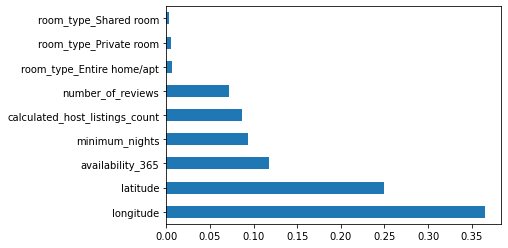

In [70]:
pd.Series(reg_forest_web_best.feature_importances_, index=features_web.columns).nlargest(20).plot(kind='barh')
plt.show()

In [72]:
dump(reg_forest_web_best, 'model_forest_web.joblib')

['model_forest_web.joblib']